### Import Statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import sys
import copy

In [2]:
%matplotlib inline

In [3]:
from funcs import matplotlib_imshow
from funcs import auto_canny
from funcs import find_contours

In [4]:
# finding contours of simple objects in an image
shape_img, img_used, shape_img_contours, shape_img_hierarchy = find_contours(
    "./imgs/simple_shapes.png", black_obj_on_white_bg=True, mode=cv.RETR_EXTERNAL
)

## Contour Approximation

The Ramer–Douglas–Peucker algorithm, also known as the Douglas–Peucker algorithm and iterative end-point fit algorithm, is an algorithm that decimates a curve composed of line segments to a similar curve with fewer points.

**It approximates a contour shape to another shape with less number of vertices** so that the distance between them is less or equal to the specified precision. It is an implementation of Douglas-Peucker algorithm. 

The purpose of the algorithm is, given a curve composed of line segments (which is also called a Polyline in some contexts), to find a similar curve with fewer points. The algorithm defines 'dissimilar' based on the maximum distance between the original curve and the simplified curve (i.e., the Hausdorff distance between the curves). The simplified curve consists of a subset of the points that defined the original curve. 

> The `cv.approxPolyDP(curve, epsilon, closed)` function for Contour Approximation

<u>Function Parameters</u>
- curve: Input vector of a 2D point array
- epsilon: Parameter specifying the approximation accuracy. This is the maximum distance between the original curve and its approximation.
- closed: If true, the approximated curve is closed (its first and last vertices are connected). Otherwise, it is not closed. 

In [5]:
star_img, star_img_used, star_contours, star_hierarchy = find_contours(
    "./imgs/star.jpeg", cv.RETR_CCOMP
)

In [6]:
def get_canvas(shape, color_code=(80, 80, 80)):
    return np.full(shape, fill_value=color_code, dtype=np.uint8)

In [7]:
canvas = get_canvas(star_img.shape)

In [9]:
# drawing all the contours of star_contours onto the canvas
cv.drawContours(canvas, star_contours, -1, (150, 200, 0), thickness=3)

# using cv.approxPloyDP() we try to find a start that has sharp edges
for cnt in star_contours:
    accuracy = 0.01 * cv.arcLength(cnt, True)
    approximated_contour = cv.approxPolyDP(cnt, accuracy, True)
    # print(len(approximated_contour), "\n", approximated_contour)
    cv.drawContours(canvas, [approximated_contour], 0, (0, 200, 100), thickness=3)

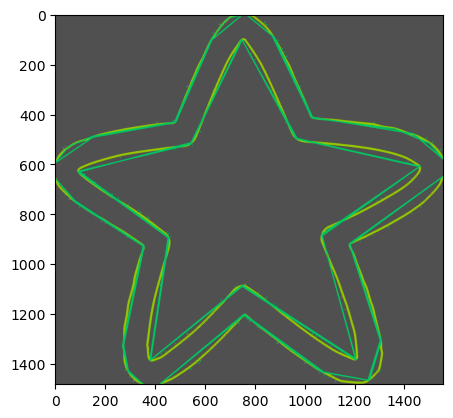

In [10]:
# showing the result
plt.imshow(canvas)

## Convex Hull

Given a set of points on a two dimensional plane, Convex Hull of this set of points is a polygon that encloses all of those points. The vertices of this polygon maximizes the area while minimizing the circumference.

<img src="./imgs/convex_hull.png">

> The `cv.convexHull(points, clockwise, returnPoints)` function

<u>Function Parameters</u>
- points: a set of points around which the convex hull is to be found. The contours we pass into.
- clockwise: Orientation flag. If it is True, the output convex hull is oriented clockwise. Otherwise, it is oriented counter-clockwise. 
- returnPoints : By default, True. Then it returns the coordinates of the hull points. If False, it returns the indices of contour points corresponding to the hull points.

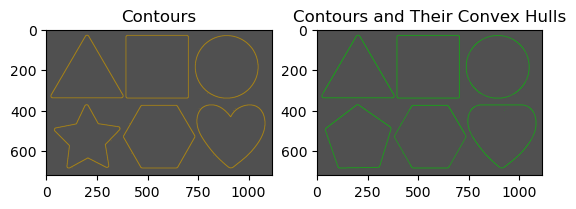

In [11]:
canvas_1 = get_canvas(shape_img.shape)
canvas_2 = get_canvas(shape_img.shape)
for cnt in shape_img_contours:
    hull = cv.convexHull(cnt)
    plt.subplot(1, 2, 1).imshow(
        cv.drawContours(canvas_1, [cnt], -1, (200, 150, 0), 2)
    ), plt.title("Contours")
    plt.subplot(1, 2, 2).imshow(
        cv.drawContours(canvas_2, [hull], -1, (0, 200, 0), 2)
    ), plt.title("Contours and Their Convex Hulls")
plt.show()

## Match Shapes ([Docs](https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html))

OpenCV comes with a function cv.matchShapes() which enables us to compare two shapes, or two contours and returns a metric showing the similarity. It is calculated based on the hu-moment values. **The lower the result, the better match it is.**

Hu-Moments are seven moments invariant to translation, rotation and scale. Seventh one is skew-invariant. Those values can be found using `cv.HuMoments()` function.

> The `cv.matchShapes(cnt1, cnt2, method)` function

<u>Function Parameters</u>
- method: Shape matching methods ([Docs](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gaf2b97a230b51856d09a2d934b78c015f)). 
    - cv.CONTOURS_MATCH_I1
    - cv.CONTOURS_MATCH_I2
    - cv.CONTOURS_MATCH_I3
- parameter: Method-specific parameter

In [12]:
# we will go through the whole process of finding contours manually (just for paractice)
img = cv.imread("./imgs/simple_shapes.png")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_blurred = cv.GaussianBlur(img_gray, (5, 5), sigmaX=0)
otsu_thresh_val, img_thresholded = cv.threshold(
    img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)
# as the object are orginally black we need to invert the image to properly find contours
img_to_use = cv.bitwise_not(img_thresholded)

In [13]:
# for complex shapes where you fear that storing only 2 end points will not suffice use, cv.CHAIN_APPROX_NONE
img_contours, img_hierarchy = cv.findContours(
    img_to_use, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE
)

In [14]:
heart_shaped_cnt = img_contours[1]
star_shaped_cnt = img_contours[2]

In [15]:
# convex hull of these two contours
heart_hull_cnt = cv.convexHull(heart_shaped_cnt)
star_hull_cnt = cv.convexHull(star_shaped_cnt)

In [16]:
# numpy stores data as, (rows, columns)
# opencv stores data as, (width, height)
# so it is opposite of what numpy does
canvas = get_canvas(shape_img.shape)

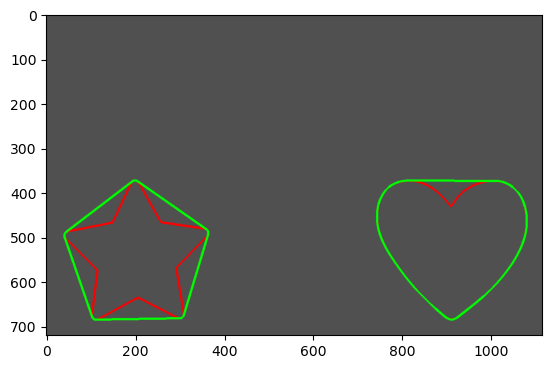

In [17]:
# contours
cv.drawContours(canvas, [star_shaped_cnt], -1, (255, 0, 0), 3)
cv.drawContours(canvas, [heart_shaped_cnt], -1, (255, 0, 0), 3)

# hulls
cv.drawContours(canvas, [star_hull_cnt], -1, (0, 255, 0), 3)
cv.drawContours(canvas, [heart_hull_cnt], -1, (0, 255, 0), 3)

plt.imshow(canvas)

In [18]:
# Finding Match Score (the lower the better)
cv.matchShapes(heart_shaped_cnt, heart_hull_cnt, cv.CONTOURS_MATCH_I1, 0)

0.08634698316527323

In [19]:
cv.matchShapes(star_shaped_cnt, star_hull_cnt, cv.CONTOURS_MATCH_I1, 0)

0.0943244676029884